Pole balancing

Based on:
<https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html>

In [42]:
import gym
import math
import numbers
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import itertools
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import utility as util

env = gym.make('CartPole-v0').unwrapped

In [2]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = util.AttrDict(
        episodes=1_000,
        minibatch_size=128,
        discount=0.999,
        eps_start=0.9,
        eps_end=0.05,
        eps_decay=200,
        update_target_interval=10,
        replay_memory_minlen=200,
        replay_memory_maxlen=10_000,
        aggregate_stats_interval=50)

In [45]:
# Transitions and Replay Memory
Transition = namedtuple('Transition',
                        ('curr_state', 'action', 'next_state', 'reward', 'is_done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [46]:
# Some attributes of Gym environment
# Reward is 1 for every step taken, including the termination step

print("Environment attributes:", *vars(env).keys())
print("Gravitational constant:", env.gravity)
print("Number of possible actions an agent can make:", env.action_space.n)
print("Sampling of discrete action space gives:", env.action_space.sample())
# The (observation) state is an array
# [Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity]
print("Current state is:", env.state)
print("States are bounded below by:", env.observation_space.low)
print("States are bounded above by:",env.observation_space.high)
# help(env.observation_space)
# help(env) # for more information

Environment attributes: gravity masscart masspole total_mass length polemass_length force_mag tau kinematics_integrator theta_threshold_radians x_threshold action_space observation_space np_random viewer state steps_beyond_done spec carttrans poletrans axle track _pole_geom
Gravitational constant: 9.8
Number of possible actions an agent can make: 2
Sampling of discrete action space gives: 1
Current state is: (0.008761879587772716, -0.2095936528406662, -0.017254931840850835, 0.29241467701314544)
States are bounded below by: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
States are bounded above by: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


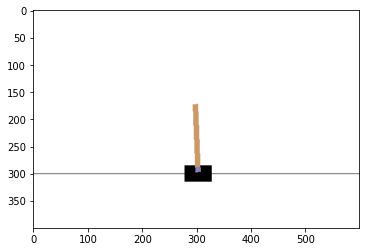

In [47]:
# Getting the first snapshot of the environment after resetting the Gym 
env.reset()
screen = env.render(mode='rgb_array')
plt.imshow(screen)

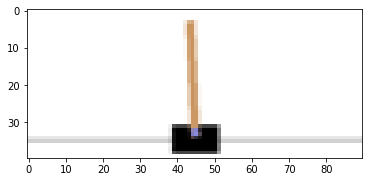

In [48]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_cart_location(env, screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def preprocess_screen(env, screen):
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = screen.transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(env, screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)

def render(env):
    return env.render(mode='rgb_array')

env.reset()
screen = render(env)
screen = preprocess_screen(env, screen)
plt.imshow(screen.cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
None

In [52]:
class DQNet(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x, is_training=True):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [63]:
class ImageStateDQNAgent(object):
    
    def __update_target_model(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.terminal_state_counter = 0

    def __init__(self, env, config, device):
        self.env = env
        self.config = config
        self.discount = self.config.discount
        self.eps_end = self.config.eps_end
        self.eps_start = self.config.eps_start
        self.eps_decay = self.config.eps_decay
        self.replay_memory_minlen = self.config.replay_memory_minlen
        self.replay_memory_maxlen = self.config.replay_memory_maxlen
        self.update_target_interval = self.config.update_target_interval
        self.minibatch_size = self.config.minibatch_size
        self.device = device
        init_screen = self.render(is_input=True)
        _, _, self.screen_height, self.screen_width = init_screen.shape
        self.n_actions = env.action_space.n
        self.policy_net = DQNet(self.screen_height, self.screen_width, self.n_actions).to(self.device)
        self.target_net = DQNet(self.screen_height, self.screen_width, self.n_actions).to(self.device)
        self.target_net.eval()
        self.__update_target_model()
        self.optimizer = optim.RMSprop(self.policy_net.parameters())
        self.criterion = nn.SmoothL1Loss()
        self.replay_memory = ReplayMemory(self.replay_memory_maxlen)
        self.steps = 0

    def update_replay_memory(self, *args):
        """
        Adds step's data to a memory replay array
        
        Parameters
        ==========
        transition : tuple
            Contains (curr_state, action, next_state, reward, is_done) where
            - curr_state : or s_t, an RGB image of dimensions (channels, height, width)
            - action     : or a_t, an integer 0-9.
            - next_state : or s_{t+1}, an RGB image of dimensions (channels, height, width)
            - reward     : or r_t, a number
            - is_done    : a boolean specifying whether s_t is a terminal state
                           where the simulation ended.
        """
        self.replay_memory.push(*args)

    @property
    def epsilon(self):
        return self.eps_end + (self.eps_start - self.eps_end) *\
            math.exp(-1. * self.steps / self.eps_decay)
        
    def select_action(self, state, is_training=True):
        sample = random.random()
        eps_threshold = self.epsilon
        if is_training:
            self.steps += 1
        if is_training and sample <= eps_threshold:
            return torch.tensor([[random.randrange(self.n_actions)]], device=self.device, dtype=torch.long)
        else:
            with torch.no_grad():
                values, indices = self.policy_net(state).max(1)
                return indices.view(1, 1)

    def __get_cart_location(self, screen_width):
        world_width = self.env.x_threshold * 2
        scale = screen_width / world_width
        return int(self.env.state[0] * scale + screen_width / 2.0)

    def __preprocess_screen(self, screen):
        # Returned screen requested by gym is 400x600x3, but is sometimes larger
        # such as 800x1200x3. Transpose it into torch order (CHW).
        screen = screen.transpose((2, 0, 1))
        # Cart is in the lower half, so strip off the top and bottom of the screen
        _, screen_height, screen_width = screen.shape
        screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
        view_width = int(screen_width * 0.6)
        cart_location = self.__get_cart_location(screen_width)
        if cart_location < view_width // 2:
            slice_range = slice(view_width)
        elif cart_location > (screen_width - view_width // 2):
            slice_range = slice(-view_width, None)
        else:
            slice_range = slice(cart_location - view_width // 2,
                                cart_location + view_width // 2)
        # Strip off the edges, so that we have a square image centered on a cart
        screen = screen[:, :, slice_range]
        # Convert to float, rescale, convert to torch tensor
        # (this doesn't require a copy)
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        # Resize, and add a batch dimension (BCHW)
        return resize(screen).unsqueeze(0)
    
    def render(self, is_input=False):
        screen = self.env.render(mode='rgb_array')
        if is_input:
            return self.__preprocess_screen(screen)
        else:
            return screen
    
    def reset(self):
        self.env.reset()
    
    def train(self, is_terminal_state=False):
        if len(self.replay_memory) < self.replay_memory_minlen:
            # Start training only if replay memory reached a minimum size
            return None
        # Get minibatch
        transitions = self.replay_memory.sample(self.minibatch_size)
        batch = Transition(*zip(*transitions))
        # Compute the current Q values
        curr_states = torch.cat(batch.curr_state)
        curr_Qs = self.policy_net(curr_states)
        # Extrac the Q values corresponding to agent actions
        actions = torch.cat(batch.action)
        curr_Qs = curr_Qs.gather(1, actions).squeeze(1)
        # Get rewards, and is_done flags.
        reward = torch.cat(batch.reward)
        is_done = torch.cat(batch.is_done)
        # Get the next states
        next_states = torch.cat([s for s in batch.next_state if s is not None])
        next_states = next_states
        # Compute the max of next Q values
        next_Qs = self.target_net(next_states, is_training=False)
        max_next_Qs, _ = next_Qs.max(dim=1)
        # Compute the expected Q values for TD error
        expected_Qs = torch.zeros(self.minibatch_size,
                dtype=torch.float, device=device)
        expected_Qs[~is_done] = reward[~is_done] + self.discount*max_next_Qs
        expected_Qs[is_done] = reward[is_done]
        # Model training step
        self.optimizer.zero_grad()
        loss = self.criterion(curr_Qs, expected_Qs)
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        # Update target model if necessary
        if is_terminal_state:
            self.terminal_state_counter += 1
        if self.terminal_state_counter > self.update_target_interval:
            self.__update_target_model()
        return loss.item()

on episode 1; epsilon 0.846507343870793
    stats aggregated over the last 50 episodes:
    avg reward 6.5
    min reward 0
    max reward 13.0
on episode 50; epsilon 0.06518391053031693
    stats aggregated over the last 50 episodes:
    avg reward 16.1
    min reward 8.0
    max reward 43.0
on episode 100; epsilon 0.05065720213084524
    stats aggregated over the last 50 episodes:
    avg reward 12.56
    min reward 8.0
    max reward 23.0
on episode 150; epsilon 0.050003849686161436
    stats aggregated over the last 50 episodes:
    avg reward 20.56
    min reward 8.0
    max reward 61.0
on episode 200; epsilon 0.05000000000976205
    stats aggregated over the last 50 episodes:
    avg reward 51.54
    min reward 12.0
    max reward 136.0
on episode 250; epsilon 0.05000000000000002
    stats aggregated over the last 50 episodes:
    avg reward 54.9
    min reward 10.0
    max reward 196.0
on episode 300; epsilon 0.05
    stats aggregated over the last 50 episodes:
    avg reward 47

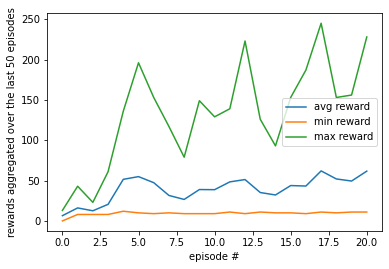

In [64]:
def imagedifference_train(env, config, device):
    env.reset()
    agent = ImageStateDQNAgent(env, config, device)
    # Reward is 1 for every step taken, including the termination step
    episode_rewards = [0]
    avgs_reward = []
    mins_reward = []
    maxs_reward = []
    for episode in range(1, config.episodes + 1):
        # agent.writer.add_scalar('epsilon', agent.epsilon, episode)
        env.reset()
        is_done = False
        episode_reward = 0
        episode_losses = []
        last_screen = agent.render(is_input=True)
        curr_screen = agent.render(is_input=True)
        curr_state = curr_screen - last_screen
        while not is_done:
            action = agent.select_action(curr_state)
            _, reward, is_done, _ = env.step(action.item())
            episode_reward += reward
            last_screen = curr_screen
            curr_screen = agent.render(is_input=True)
            if is_done:
                next_state = None
            else:
                next_state = curr_screen - last_screen
            agent.update_replay_memory(
                    curr_state,
                    action,
                    next_state,
                    torch.tensor([reward], device=device),
                    torch.tensor([is_done],dtype=torch.bool, device=device))
            loss = agent.train(is_terminal_state=is_done)
            if isinstance(loss, numbers.Number):
                episode_losses.append(loss)
            curr_state = next_state
        
        episode_rewards.append(episode_reward)
        avg_losses = sum(episode_losses) / len(episode_losses) if len(episode_losses) > 0 else 0
        # agent.writer.add_scalar('avg_loss', avg_losses, episode)
        if episode % config.aggregate_stats_interval == 0 or episode == 1:
            episode_rewards = episode_rewards[-config.aggregate_stats_interval:]
            avg_reward = sum(episode_rewards) / len(episode_rewards)
            min_reward = min(episode_rewards)
            max_reward = max(episode_rewards)
            # agent.writer.add_scalar('avg_reward', avg_reward, episode)
            # agent.writer.add_scalar('min_reward', min_reward, episode)
            # agent.writer.add_scalar('max_reward', max_reward, episode)
            avgs_reward.append(avg_reward)
            mins_reward.append(min_reward)
            maxs_reward.append(max_reward)
            print(f"on episode {episode}; epsilon {agent.epsilon}")
            print(f"    stats aggregated over the last {config.aggregate_stats_interval} episodes:")
            print(f"    avg reward {avg_reward}")
            print(f"    min reward {min_reward}")
            print(f"    max reward {max_reward}")
            
    plt.plot(np.arange(len(avgs_reward)), avgs_reward, label='avg reward')
    plt.plot(np.arange(len(mins_reward)), mins_reward, label='min reward')
    plt.plot(np.arange(len(maxs_reward)), maxs_reward, label='max reward')
    plt.legend()
    plt.ylabel(f"rewards aggregated over the last {config.aggregate_stats_interval} episodes")
    plt.xlabel(f"episode #")
    # plt.savefig(f"{agent.log_dir}/training-summary.png")
    return agent

agent = imagedifference_train(env, config, device)
plt.show()

Test the agent